* https://github.com/cjhutto/vaderSentiment#about-the-scoring
* http://www.cic.ipn.mx/~sidorov/#SEL
* http://tass.sepln.org/tass_data/download.php

### Análisis de sentimientos utilizando vaderSentiment

In [56]:
import nltk
from gensim import models
import pandas 
import json
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

#Análisis de sentimientos
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [83]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = numpy.trace(cm) / numpy.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = numpy.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Valores reales')
    plt.xlabel('Valores predichos\Exactitud={:0.2f}; Tasa de error={:0.2f}'.format(accuracy, misclass))
    plt.show()

##### Editamos el LEXICON que viene integrado en SentimentalIntensityAnalizer 

In [57]:
lexicon = pandas.read_csv('SEL/SEL_UTF8.txt', sep='\t', names=['Palabra', 'PFA', 'Categoría'])
lexicon.drop(['Categoría'], axis='columns', inplace=True)
lexicon.info()

Palabras = numpy.array(lexicon.Palabra)
PFA = numpy.array(lexicon.PFA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2037 entries, 0 to 2036
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Palabra  2037 non-null   object
 1   PFA      2037 non-null   object
dtypes: object(2)
memory usage: 32.0+ KB


In [58]:
lista = []
for i in range(1, len(Palabras)):
    lista.append([Palabras[i], float(PFA[i])])
    
lexi = {a : b for a,b in lista}
lexi

{'abundancia': 0.83,
 'acabalar': 0.396,
 'acallar': 0.198,
 'acatar': 0.198,
 'acción': 0.397,
 'aceptable': 0.594,
 'aceptación': 0.696,
 'acicate': 0.429,
 'aclamación': 0.799,
 'aclamar': 0.799,
 'acogedor': 0.83,
 'acoger': 0.729,
 'acomodadamente': 0.729,
 'acuciar': 0.264,
 'acucioso': 0.232,
 'adecuar': 0.331,
 'adicto': 0.429,
 'admirable': 0.73,
 'admirablemente': 0.663,
 'admiración': 0.764,
 'admirar': 0.73,
 'admitir': 0.53,
 'adorable': 0.898,
 'adorablemente': 0.865,
 'adoración': 0.765,
 'adorador': 0.664,
 'adorar': 0.764,
 'afable': 0.696,
 'afán': 0.764,
 'afectivo': 0.864,
 'afecto': 0.899,
 'afectuosamente': 0.966,
 'afectuosidad': 0.932,
 'afectuoso': 0.898,
 'afervorizar': 0.731,
 'afición': 0.729,
 'aficionar': 0.595,
 'afortunadamente': 0.831,
 'afortunado': 0.932,
 'agradable': 0.899,
 'agradar': 0.798,
 'agradecer': 0.763,
 'agradecido': 0.764,
 'agudeza': 0.331,
 'aguzar': 0.199,
 'ahínco': 0.73,
 'ahíto': 0.564,
 'airoso': 0.565,
 'alabar': 0.53,
 'alboroza

##### Integramos el nuevo Lexicon al lexicon base 

In [59]:
SIA = SentimentIntensityAnalyzer()
SIA.lexicon.update(lexi)

## TEST

In [61]:
tweets = pandas.read_csv(".//TweetsTrainSentiment//TweetsClasificados.csv", names=['Tweet', 'Polaridad'])
tweets =tweets.dropna()
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 0 to 1976
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      989 non-null    object
 1   Polaridad  989 non-null    object
dtypes: object(2)
memory usage: 23.2+ KB


#### Eliminamos las clasificaciones NONE

In [62]:
cleanTweets = []
pol = tweets.Polaridad.values.tolist()
tw = tweets.Tweet.values.tolist()
for i in range(len(pol)):
    if (pol[i] != 'NONE'):
        cleanTweets.append(([tw[i], pol[i]]))
        
CT = numpy.asarray(cleanTweets)
print("Tweets totales = ", len(CT))

positivos = 0
negativos = 0
neutrales = 0
for i in range(len(CT)):
    if (CT[i][1] == 'P'):
        positivos += 1
    if (CT[i][1] == 'N'):
        negativos += 1
    if (CT[i][1] == 'NEU'):
        neutrales += 1
        
        
print("Positivos = ", positivos, "Negativos = ", negativos, "Neutrales = ", neutrales)
n_classes = len(['P', 'N', 'NEU'])

Tweets totales =  896
Positivos =  312 Negativos =  505 Neutrales =  79


In [87]:
X = CT[:,0]
Y = CT[:,1]
print(len(Y))
x, X_test, y, y_test = train_test_split(X, Y, test_size=0.9, random_state=100)

data = []
for i in range(len(X_test)):
    data.append([X_test[i], y_test[i]])
    
print(data[0])

896
['Días!!! Suelta las viejas creencias. Cambia tu energía. Cruza los límites imaginarios. Usa tu corazón. Libera tu niño interior... Besitos', 'P']


In [90]:
res = []
pos = 0
for i in range(len(data)):
    tweet = data[i][0]
    vs = SIA.polarity_scores(tweet)
    auxArr = numpy.split(numpy.asarray(list(vs.items())).T, 2)
    values = numpy.asarray(auxArr[1], dtype =float).flatten()
    compound = values[3]
    #print(compound)
    
    if(compound >= 0.05):
        pos += 1
        res.append(['P'])
    elif(compound <= -0.05):
        res.append(['N'])
    else: #(compound > -0.05 and compound < 0.05):
        res.append(['NEU'])
        

print(pos)

273


In [91]:
labels = ['P', 'N', 'NEU']
cm = numpy.asarray(confusion_matrix(y_test, res, labels), dtype=numpy.uint8)
print(cm)

[[119  52 110]
 [136 158 163]
 [ 18  32  19]]


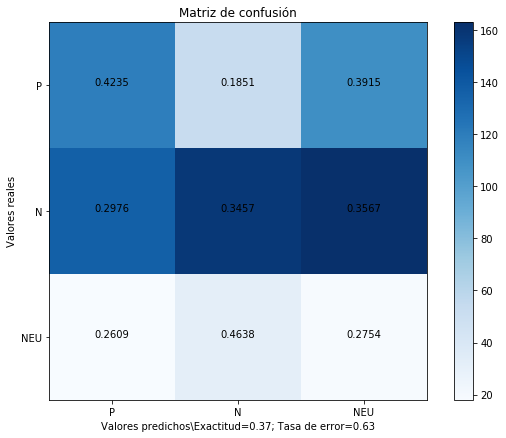

In [92]:
plot_confusion_matrix(cm,
                      labels,
                      title='Matriz de confusión',
                      cmap=None,
                      normalize=True)